In [1]:
# Function to get data

import os
from six.moves.urllib.request import urlretrieve
import gzip, binascii, struct, numpy

SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
WORK_DIRECTORY = "/tmp/mnist-data"
IMAGE_SIZE = 28
PIXEL_DEPTH = 255
VALIDATION_SIZE = 5000
NUM_LABELS = 10

def maybe_download(filename):
    """A helper to download the data files if not present."""
    if not os.path.exists(WORK_DIRECTORY):
        os.mkdir(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urlretrieve(SOURCE_URL + filename, filepath)
        statinfo = os.stat(filepath)
        print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    else:
        print('Already downloaded', filename)
    return filepath

def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
  
    For MNIST data, the number of channels is always 1.

    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        # Skip the magic number and dimensions; we know these values.
        bytestream.read(16)

        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images)
        data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, 1)
        return data

def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        # Skip the magic number and count; we know these values.
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = numpy.frombuffer(buf, dtype=numpy.uint8)
    # Convert to dense 1-hot representation.
    return (numpy.arange(NUM_LABELS) == labels[:, None]).astype(numpy.float32)

def get_data():
    train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
    train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
    test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
    test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

    train_data = extract_data(train_data_filename, 60000)
    test_data = extract_data(test_data_filename, 10000)
    train_labels = extract_labels(train_labels_filename, 60000)
    test_labels = extract_labels(test_labels_filename, 10000)

    validation_data = train_data[:VALIDATION_SIZE, :, :, :]
    validation_labels = train_labels[:VALIDATION_SIZE]
    train_data = train_data[VALIDATION_SIZE:, :, :, :]
    train_labels = train_labels[VALIDATION_SIZE:]
    train_size = train_labels.shape[0]
    print('Validation shape', validation_data.shape)
    print('Train size', train_size)
    
    return train_data, train_labels, validation_data, validation_labels
X_train, y_train, X_val, y_val = mnist_data.get_data()

Already downloaded train-images-idx3-ubyte.gz
Already downloaded train-labels-idx1-ubyte.gz
Already downloaded t10k-images-idx3-ubyte.gz
Already downloaded t10k-labels-idx1-ubyte.gz
Extracting /tmp/mnist-data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist-data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist-data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist-data/t10k-labels-idx1-ubyte.gz
Validation shape (5000, 28, 28, 1)
Train size 55000


Training data shape (55000, 28, 28, 1)


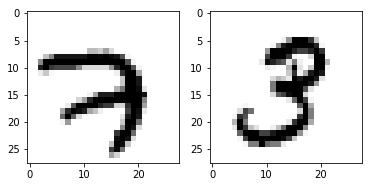

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(28, 28), cmap=plt.cm.Greys);

In [3]:
import tensorflow as tf

features_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1])
labels_placeholder = tf.placeholder(tf.float32, [None, 10])
batch_size_placeholder = tf.placeholder(tf.int64, [])

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
dataset = dataset.batch(batch_size_placeholder)
dataset = dataset.repeat(100)
iterator = dataset.make_initializable_iterator()
x_batch, y_batch = iterator.get_next()

In [4]:
# Weights Init
conv1_weights = tf.get_variable("conv1", shape=[5, 5, 1, 32], initializer=tf.contrib.layers.xavier_initializer())
conv1_biases  = tf.get_variable("conv1_bias", shape=[32], initializer=tf.zeros_initializer())

conv2_weights = tf.get_variable("conv2", shape=[5, 5, 32, 64], initializer=tf.contrib.layers.xavier_initializer())
conv2_biases  = tf.get_variable("conv2_bias", shape=[64], initializer=tf.zeros_initializer())

fc1_weights = tf.get_variable("fc1", shape=[7*7*64, 512], initializer=tf.contrib.layers.xavier_initializer())
fc1_biases = tf.get_variable("fc1_bias", shape=[512], initializer=tf.zeros_initializer())

fc2_weights = tf.get_variable("fc2", shape=[512, 10], initializer=tf.contrib.layers.xavier_initializer())
fc2_biases = tf.get_variable("fc2_bias", shape=[10], initializer=tf.zeros_initializer())

def model(data):
    """The Model definition."""
    conv = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
    pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    conv = tf.nn.conv2d(pool, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [-1, pool_shape[1] * pool_shape[2] * pool_shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

    return tf.matmul(hidden, fc2_weights) + fc2_biases

print('Done')



Done


In [5]:
counter = tf.Variable(0)
logits = model(x_batch)
prediction = tf.nn.softmax(logits)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_batch, logits=logits))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 1e-1)
train_op = optimizer.minimize(loss, global_step=counter)

In [6]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)
sess.run(iterator.initializer, feed_dict={features_placeholder: X_train, labels_placeholder: y_train, batch_size_placeholder: 64})



In [7]:
steps = y_train.shape[0]*5 // 64
for step in range(steps):
    _, l = sess.run([train_op, loss])
    if step % 1000 == 0:
        print('loss: ', l)

loss:  2.3070822
loss:  0.1530393
loss:  0.0068216682
loss:  0.0033742092
loss:  0.011832637


In [9]:
sess.run(iterator.initializer, feed_dict={features_placeholder: X_val, labels_placeholder: y_val, batch_size_placeholder: y_val.shape[0]})

In [10]:
np_pred, np_loss, np_labels = sess.run([prediction, loss, y_batch])

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np
confusion_matrix(np.argmax(np_pred, axis=1), np.argmax(np_labels, axis=1))

array([[478,   0,   0,   0,   0,   0,   2,   0,   0,   1],
       [  0, 561,   1,   0,   0,   1,   2,   2,   1,   1],
       [  1,   0, 486,   5,   0,   1,   2,   3,   8,   1],
       [  0,   0,   0, 484,   0,   1,   0,   0,   1,   0],
       [  0,   0,   0,   0, 533,   0,   0,   1,   1,   1],
       [  0,   0,   0,   0,   0, 429,   0,   1,   1,   0],
       [  0,   0,   0,   0,   0,   0, 495,   0,   1,   1],
       [  0,   2,   0,   3,   1,   0,   0, 543,   0,   5],
       [  0,   0,   0,   0,   0,   1,   0,   0, 448,   1],
       [  0,   0,   1,   1,   1,   1,   0,   0,   1, 484]])

Training data shape (55000, 28, 28, 1)


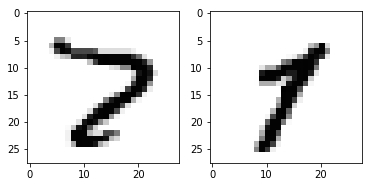

In [12]:
# View images that we failed to classify out of interest

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_val[~(np.argmax(np_pred, axis=1)==np.argmax(np_labels, axis=1))][32].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(X_val[~(np.argmax(np_pred, axis=1)==np.argmax(np_labels, axis=1))][30].reshape(28, 28), cmap=plt.cm.Greys);

